## CIFAR10 VQ-VAE

In [91]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR10 train dataset
train_set = torchvision.datasets.CIFAR10(root='~/data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)

# Load the CIFAR10 test dataset
test_set = torchvision.datasets.CIFAR10(root='~/data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [92]:
# Define the encoder architecture
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, latent_dim, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        return x

# Define the decoder architecture
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.deconv4(x)
        x = self.tanh(x)
        return x


In [93]:
class Quantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(Quantizer, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        # w/o this line, the model will not learn
        self.embedding.weight.data.uniform_(-1./num_embeddings, 1./num_embeddings)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        
    def forward(self, z_e):
        # z_e - encoder latent code (B, C, H, W) -> (B, H, W, C)
        z_e = z_e.permute(0, 2, 3, 1).contiguous()
        z_e_shape = z_e.shape
        # flat version of z_e
        flat_z_e = z_e.view(-1, self.embedding_dim)

        # distance between z_e and embeddings
        distances = (torch.sum(flat_z_e**2, dim=1, keepdim=True) 
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_z_e, self.embedding.weight.t()))
        
        # minimal distance between z_e and embeddings
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=z_e.device)
        # one-hot vector based on the minimal distance
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        # N one-hot encodings quantizing/filtering by 0 or 1 each dim (col) of embedding
        # The encodings builds a map of which feature point of each feature embedding vector is used
        z_q = torch.matmul(encodings, self.embedding.weight).view(z_e_shape)
        
        # What is the purpose of z_q + (z_e - z_q).detach()?
        z_q = z_e + (z_q - z_e).detach()
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return z_q, encoding_indices

In [94]:
class VQVAE(nn.Module):
    def __init__(self, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.quantizer = Quantizer(num_embeddings, embedding_dim)
    
    def forward(self, x):
        z_e = self.encoder(x)
        z_q, encoding_indices = self.quantizer(z_e)
        x_hat = self.decoder(z_q)
        return x_hat, z_e, z_q, encoding_indices



In [95]:
latent_dim = 2048
num_embeddings = 512
embedding_dim = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQVAE(latent_dim, num_embeddings, embedding_dim).to(device)

In [96]:
random_input = torch.randn(1, 3, 32, 32).to(device)
z_e = model.encoder(random_input)
z_q, indeces = model.quantizer(z_e)
print(z_q.shape, indeces.shape)
x_hat = model.decoder(z_q)
print(x_hat.shape)

torch.Size([1, 2048, 2, 2]) torch.Size([512, 1])
torch.Size([1, 3, 32, 32])


In [97]:
# Set the number of epochs
num_epochs = 50

# Create an optimizer
optimizer = optim.Adam(model.parameters())
# Print the number of parameters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Train the model
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    r_loss = 0
    c_loss = 0
    l_loss = 0  
    total = 0 
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move the data to the device
        data = data.to(device)
        total += data.size(0)
        
        # Forward pass
        x_hat, z_e, z_q, indices = model(data)
        recon_loss = nn.MSELoss()(x_hat, data)
        commit_loss = nn.MSELoss()(z_e.detach(), z_q)
        latent_loss = nn.MSELoss()(z_e, z_q.detach())
        loss = recon_loss + 0.25 * commit_loss + latent_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        r_loss += recon_loss.item()
        c_loss += commit_loss.item()
        l_loss += latent_loss.item()
    
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Ave Loss: {total_loss/total:.4f}, Recon Loss: {r_loss/total:.4f}, Commit Loss: {c_loss/total:.4f}, Latent Loss: {l_loss/total:.4f}")

Number of parameters: 18105231


  2%|▏         | 1/50 [00:04<03:38,  4.46s/it]

Epoch [1/50], Ave Loss: 8.0734, Recon Loss: 0.0019, Commit Loss: 6.4572, Latent Loss: 6.4572


  4%|▍         | 2/50 [00:09<03:39,  4.57s/it]

Epoch [2/50], Ave Loss: 0.6572, Recon Loss: 0.0009, Commit Loss: 0.5251, Latent Loss: 0.5251


  6%|▌         | 3/50 [00:13<03:32,  4.51s/it]

Epoch [3/50], Ave Loss: 0.3447, Recon Loss: 0.0007, Commit Loss: 0.2752, Latent Loss: 0.2752


  8%|▊         | 4/50 [00:18<03:27,  4.50s/it]

Epoch [4/50], Ave Loss: 0.2560, Recon Loss: 0.0006, Commit Loss: 0.2043, Latent Loss: 0.2043


 10%|█         | 5/50 [00:22<03:22,  4.50s/it]

Epoch [5/50], Ave Loss: 0.2495, Recon Loss: 0.0006, Commit Loss: 0.1991, Latent Loss: 0.1991


 12%|█▏        | 6/50 [00:27<03:19,  4.52s/it]

Epoch [6/50], Ave Loss: 0.2721, Recon Loss: 0.0005, Commit Loss: 0.2173, Latent Loss: 0.2173


 14%|█▍        | 7/50 [00:31<03:14,  4.53s/it]

Epoch [7/50], Ave Loss: 0.2741, Recon Loss: 0.0005, Commit Loss: 0.2189, Latent Loss: 0.2189


 16%|█▌        | 8/50 [00:36<03:10,  4.53s/it]

Epoch [8/50], Ave Loss: 0.2983, Recon Loss: 0.0004, Commit Loss: 0.2383, Latent Loss: 0.2383


 18%|█▊        | 9/50 [00:40<03:05,  4.52s/it]

Epoch [9/50], Ave Loss: 0.3154, Recon Loss: 0.0004, Commit Loss: 0.2520, Latent Loss: 0.2520


 20%|██        | 10/50 [00:45<03:01,  4.53s/it]

Epoch [10/50], Ave Loss: 0.3212, Recon Loss: 0.0004, Commit Loss: 0.2567, Latent Loss: 0.2567


 22%|██▏       | 11/50 [00:49<02:58,  4.57s/it]

Epoch [11/50], Ave Loss: 0.3368, Recon Loss: 0.0004, Commit Loss: 0.2691, Latent Loss: 0.2691


 24%|██▍       | 12/50 [00:54<02:52,  4.55s/it]

Epoch [12/50], Ave Loss: 0.3502, Recon Loss: 0.0003, Commit Loss: 0.2799, Latent Loss: 0.2799


 26%|██▌       | 13/50 [00:58<02:48,  4.54s/it]

Epoch [13/50], Ave Loss: 0.3433, Recon Loss: 0.0003, Commit Loss: 0.2744, Latent Loss: 0.2744


 28%|██▊       | 14/50 [01:03<02:43,  4.54s/it]

Epoch [14/50], Ave Loss: 0.3355, Recon Loss: 0.0003, Commit Loss: 0.2681, Latent Loss: 0.2681


 30%|███       | 15/50 [01:07<02:38,  4.53s/it]

Epoch [15/50], Ave Loss: 0.3349, Recon Loss: 0.0003, Commit Loss: 0.2677, Latent Loss: 0.2677


 32%|███▏      | 16/50 [01:12<02:34,  4.54s/it]

Epoch [16/50], Ave Loss: 0.3263, Recon Loss: 0.0003, Commit Loss: 0.2608, Latent Loss: 0.2608


 34%|███▍      | 17/50 [01:16<02:28,  4.51s/it]

Epoch [17/50], Ave Loss: 0.3238, Recon Loss: 0.0003, Commit Loss: 0.2588, Latent Loss: 0.2588


 36%|███▌      | 18/50 [01:21<02:25,  4.55s/it]

Epoch [18/50], Ave Loss: 0.3307, Recon Loss: 0.0003, Commit Loss: 0.2644, Latent Loss: 0.2644


 38%|███▊      | 19/50 [01:26<02:21,  4.56s/it]

Epoch [19/50], Ave Loss: 0.3474, Recon Loss: 0.0003, Commit Loss: 0.2777, Latent Loss: 0.2777


 40%|████      | 20/50 [01:30<02:15,  4.53s/it]

Epoch [20/50], Ave Loss: 0.3516, Recon Loss: 0.0003, Commit Loss: 0.2811, Latent Loss: 0.2811


 42%|████▏     | 21/50 [01:35<02:10,  4.51s/it]

Epoch [21/50], Ave Loss: 0.3580, Recon Loss: 0.0003, Commit Loss: 0.2862, Latent Loss: 0.2862


 44%|████▍     | 22/50 [01:39<02:06,  4.50s/it]

Epoch [22/50], Ave Loss: 0.3629, Recon Loss: 0.0003, Commit Loss: 0.2901, Latent Loss: 0.2901


 46%|████▌     | 23/50 [01:44<02:01,  4.50s/it]

Epoch [23/50], Ave Loss: 0.3748, Recon Loss: 0.0003, Commit Loss: 0.2996, Latent Loss: 0.2996


 48%|████▊     | 24/50 [01:48<01:57,  4.51s/it]

Epoch [24/50], Ave Loss: 0.3823, Recon Loss: 0.0003, Commit Loss: 0.3056, Latent Loss: 0.3056


 50%|█████     | 25/50 [01:53<01:52,  4.51s/it]

Epoch [25/50], Ave Loss: 0.3806, Recon Loss: 0.0003, Commit Loss: 0.3043, Latent Loss: 0.3043


 52%|█████▏    | 26/50 [01:57<01:49,  4.58s/it]

Epoch [26/50], Ave Loss: 0.3798, Recon Loss: 0.0002, Commit Loss: 0.3036, Latent Loss: 0.3036


 54%|█████▍    | 27/50 [02:02<01:45,  4.58s/it]

Epoch [27/50], Ave Loss: 0.3828, Recon Loss: 0.0002, Commit Loss: 0.3061, Latent Loss: 0.3061


 56%|█████▌    | 28/50 [02:06<01:40,  4.55s/it]

Epoch [28/50], Ave Loss: 0.3799, Recon Loss: 0.0002, Commit Loss: 0.3037, Latent Loss: 0.3037


 58%|█████▊    | 29/50 [02:11<01:35,  4.55s/it]

Epoch [29/50], Ave Loss: 0.3810, Recon Loss: 0.0002, Commit Loss: 0.3046, Latent Loss: 0.3046


 60%|██████    | 30/50 [02:15<01:30,  4.53s/it]

Epoch [30/50], Ave Loss: 0.3841, Recon Loss: 0.0002, Commit Loss: 0.3071, Latent Loss: 0.3071


 62%|██████▏   | 31/50 [02:20<01:25,  4.52s/it]

Epoch [31/50], Ave Loss: 0.3859, Recon Loss: 0.0002, Commit Loss: 0.3085, Latent Loss: 0.3085


 64%|██████▍   | 32/50 [02:24<01:20,  4.50s/it]

Epoch [32/50], Ave Loss: 0.3877, Recon Loss: 0.0002, Commit Loss: 0.3100, Latent Loss: 0.3100


 66%|██████▌   | 33/50 [02:29<01:17,  4.55s/it]

Epoch [33/50], Ave Loss: 0.4061, Recon Loss: 0.0002, Commit Loss: 0.3247, Latent Loss: 0.3247


 68%|██████▊   | 34/50 [02:34<01:12,  4.56s/it]

Epoch [34/50], Ave Loss: 0.4308, Recon Loss: 0.0002, Commit Loss: 0.3444, Latent Loss: 0.3444


 70%|███████   | 35/50 [02:38<01:07,  4.53s/it]

Epoch [35/50], Ave Loss: 0.4325, Recon Loss: 0.0002, Commit Loss: 0.3458, Latent Loss: 0.3458


 72%|███████▏  | 36/50 [02:43<01:03,  4.51s/it]

Epoch [36/50], Ave Loss: 0.4417, Recon Loss: 0.0002, Commit Loss: 0.3532, Latent Loss: 0.3532


 74%|███████▍  | 37/50 [02:47<00:58,  4.49s/it]

Epoch [37/50], Ave Loss: 0.4338, Recon Loss: 0.0002, Commit Loss: 0.3469, Latent Loss: 0.3469


 76%|███████▌  | 38/50 [02:51<00:53,  4.49s/it]

Epoch [38/50], Ave Loss: 0.4366, Recon Loss: 0.0002, Commit Loss: 0.3491, Latent Loss: 0.3491


 78%|███████▊  | 39/50 [02:56<00:49,  4.49s/it]

Epoch [39/50], Ave Loss: 0.4424, Recon Loss: 0.0002, Commit Loss: 0.3537, Latent Loss: 0.3537


 80%|████████  | 40/50 [03:01<00:45,  4.55s/it]

Epoch [40/50], Ave Loss: 0.4494, Recon Loss: 0.0002, Commit Loss: 0.3594, Latent Loss: 0.3594


 82%|████████▏ | 41/50 [03:05<00:40,  4.53s/it]

Epoch [41/50], Ave Loss: 0.4514, Recon Loss: 0.0002, Commit Loss: 0.3609, Latent Loss: 0.3609


 84%|████████▍ | 42/50 [03:10<00:36,  4.51s/it]

Epoch [42/50], Ave Loss: 0.4504, Recon Loss: 0.0002, Commit Loss: 0.3601, Latent Loss: 0.3601


 86%|████████▌ | 43/50 [03:14<00:31,  4.51s/it]

Epoch [43/50], Ave Loss: 0.4501, Recon Loss: 0.0002, Commit Loss: 0.3599, Latent Loss: 0.3599


 88%|████████▊ | 44/50 [03:19<00:26,  4.50s/it]

Epoch [44/50], Ave Loss: 0.4476, Recon Loss: 0.0002, Commit Loss: 0.3579, Latent Loss: 0.3579


 90%|█████████ | 45/50 [03:23<00:22,  4.49s/it]

Epoch [45/50], Ave Loss: 0.4432, Recon Loss: 0.0002, Commit Loss: 0.3544, Latent Loss: 0.3544


 92%|█████████▏| 46/50 [03:28<00:17,  4.49s/it]

Epoch [46/50], Ave Loss: 0.4448, Recon Loss: 0.0002, Commit Loss: 0.3557, Latent Loss: 0.3557


 94%|█████████▍| 47/50 [03:32<00:13,  4.50s/it]

Epoch [47/50], Ave Loss: 0.4455, Recon Loss: 0.0002, Commit Loss: 0.3563, Latent Loss: 0.3563


 96%|█████████▌| 48/50 [03:37<00:09,  4.53s/it]

Epoch [48/50], Ave Loss: 0.4566, Recon Loss: 0.0002, Commit Loss: 0.3651, Latent Loss: 0.3651


 98%|█████████▊| 49/50 [03:41<00:04,  4.52s/it]

Epoch [49/50], Ave Loss: 0.4753, Recon Loss: 0.0002, Commit Loss: 0.3801, Latent Loss: 0.3801


100%|██████████| 50/50 [03:46<00:00,  4.52s/it]

Epoch [50/50], Ave Loss: 0.4722, Recon Loss: 0.0002, Commit Loss: 0.3776, Latent Loss: 0.3776


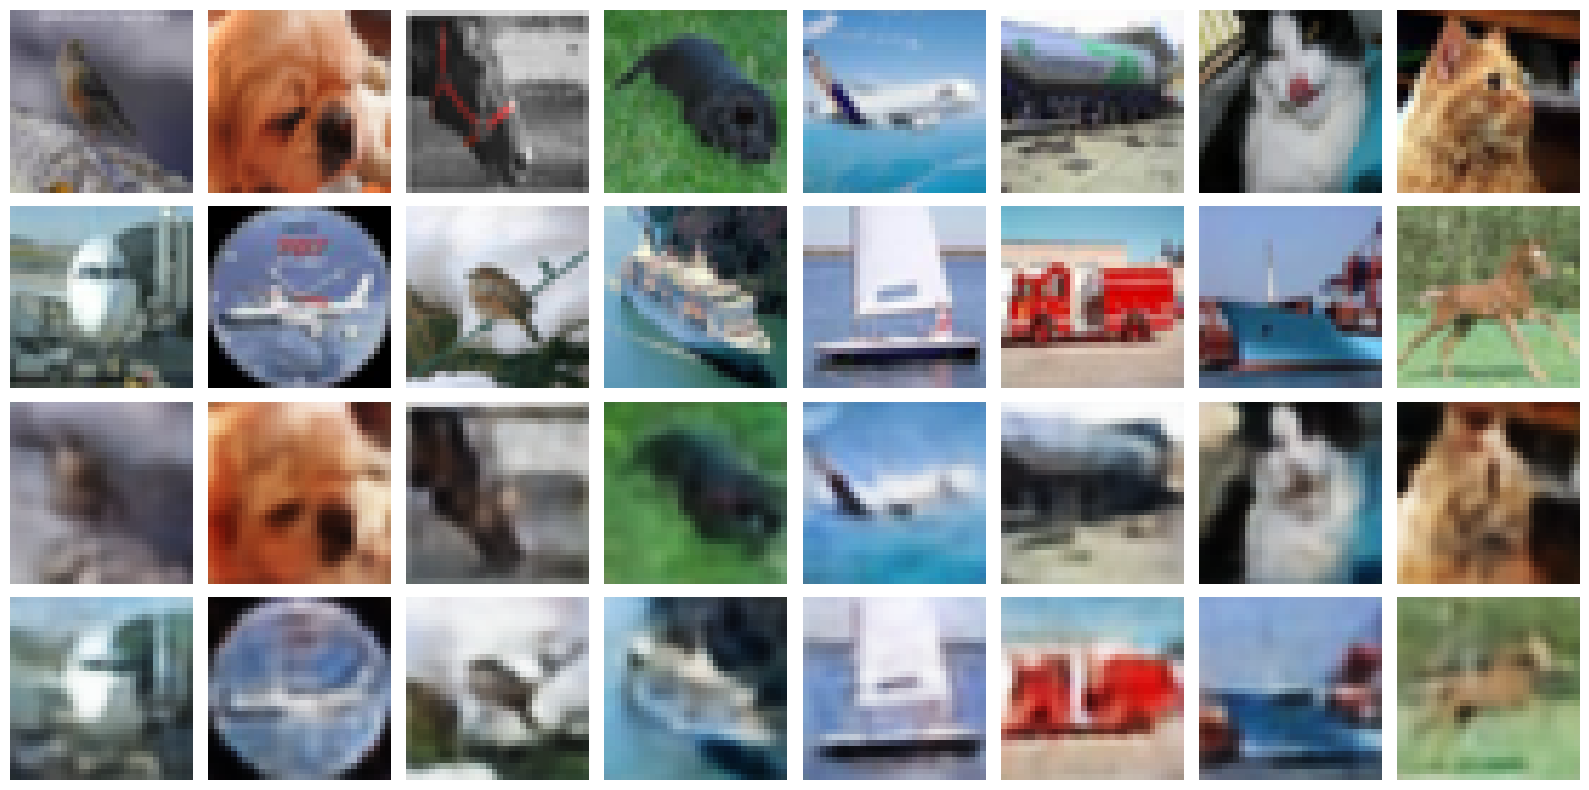

In [98]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Sample 16 images from the test set
sample_indices = torch.randint(len(test_set), (16,))
sample_images = torch.stack([test_set[i][0] for i in sample_indices])

# Move the sample images to the same device as the model
sample_images = sample_images.to(device)

# Pass the sample images through the model
with torch.no_grad():
    recon_images, _, _, _ = model(sample_images)

# Convert the images to numpy arrays
sample_images = sample_images.cpu().numpy()
recon_images = recon_images.cpu().numpy()

# Rescale the images from [-1, 1] to [0, 1]
sample_images = (sample_images + 1) / 2
recon_images = (recon_images + 1) / 2

# Plot the original and reconstructed images
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.flatten()

for i in range(16):
    axes[i].imshow(sample_images[i].transpose(1, 2, 0))
    axes[i].axis('off')
    axes[i + 16].imshow(recon_images[i].transpose(1, 2, 0))
    axes[i + 16].axis('off')

plt.tight_layout()
plt.show()
